In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

import warnings
warnings.filterwarnings("ignore")

/Users/rsilvei/Envs/bayesian/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
az.style.use('arviz-darkgrid')

## PyMC3 primer

In [11]:
np.random.seed(123)
trials = 4
theta_real = 0.35  # unknown value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=trials)
data

array([1, 0, 0, 0])

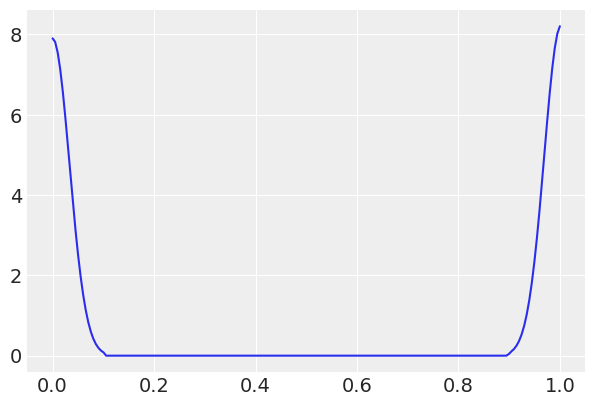

In [6]:
az.plot_kde(stats.bernoulli.rvs(p=theta_real, size=1000))

In [12]:
data.mean()

0.25

In [23]:
with pm.Model() as our_first_model:
    # a priori
    θ = pm.Beta('θ', alpha=1., beta=1.)
    # likelihood
    y = pm.Bernoulli('y', p=θ, observed=data)
    trace = pm.sample(5000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ_logodds__]
100%|██████████| 5500/5500 [00:02<00:00, 2314.04it/s]


### Summarizing the posterior

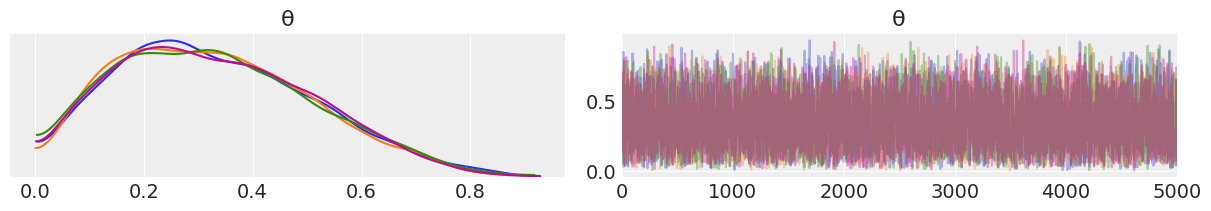

In [24]:
az.plot_trace(trace)
plt.savefig('B11197_02_01.png')

In [26]:
az.summary(trace)

,mean,sd,mc error,hpd 3%,hpd 97%,ess,r_hat
θ,0.33,0.18,0.0,0.03,0.65,8714.0,1.0


#### Posterior-based decisions

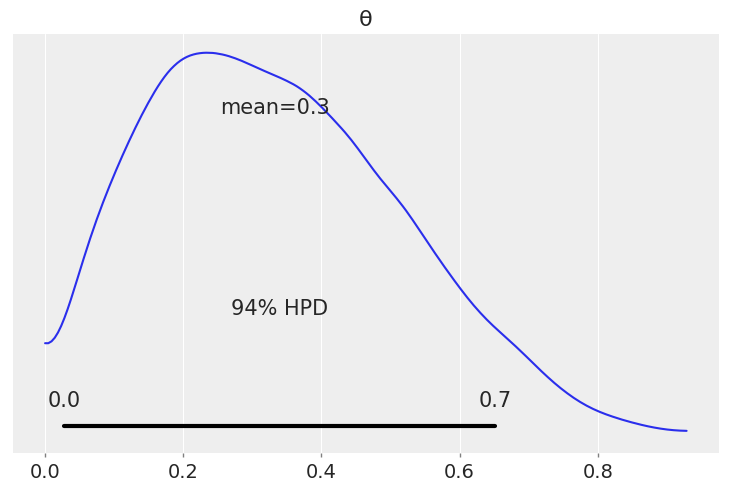

In [27]:
az.plot_posterior(trace)
plt.savefig('B11197_02_02.png', dpi=300)

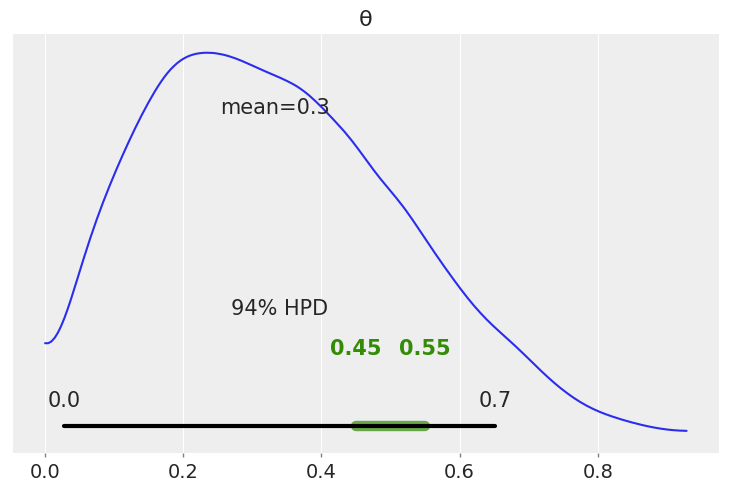

In [30]:
az.plot_posterior(trace, rope=[0.45, .55])
plt.savefig('B11197_02_03.png', dpi=300)

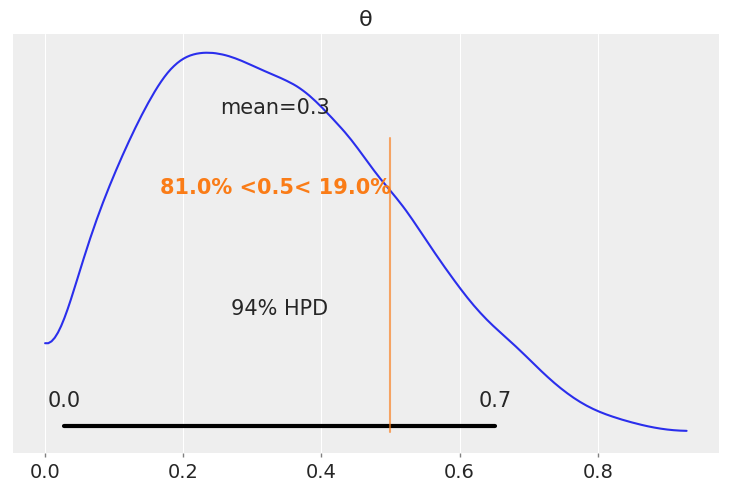

In [31]:
az.plot_posterior(trace, ref_val=0.5)
plt.savefig('B11197_02_04.png', dpi=300)

In [34]:
trace.stat_names

{'depth',
 'diverging',
 'energy',
 'energy_error',
 'max_energy_error',
 'mean_tree_accept',
 'step_size',
 'step_size_bar',
 'tree_size',
 'tune'}

In [42]:
samples = 5000
trace['θ'][0:samples].mean()

0.33652327922310826

In [43]:
trace['θ'][samples+1:2*samples].mean()

0.33037768717411814

In [44]:
trace['θ'][2*samples+1:3*samples].mean()

0.3333213579545972

In [45]:
trace['θ'][3*samples+1:4*samples].mean()

0.3346972163991913

In [38]:
trace['θ']

array([0.30763971, 0.1216395 , 0.15587282, ..., 0.03797402, 0.6617086 ,
       0.66133541])

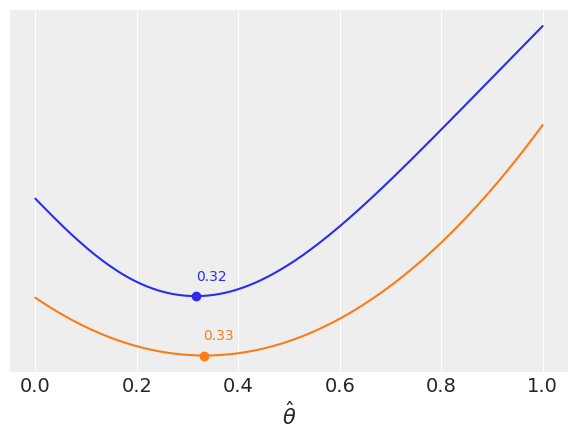

In [46]:
grid = np.linspace(0, 1, 200)
θ_pos = trace['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]

for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.2f}'.format(grid[mini]),
                 (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')
plt.savefig('B11197_02_05.png', dpi=300)

In [47]:
np.mean(θ_pos), np.median(θ_pos)

(0.33373317605017244, 0.31666995043511553)

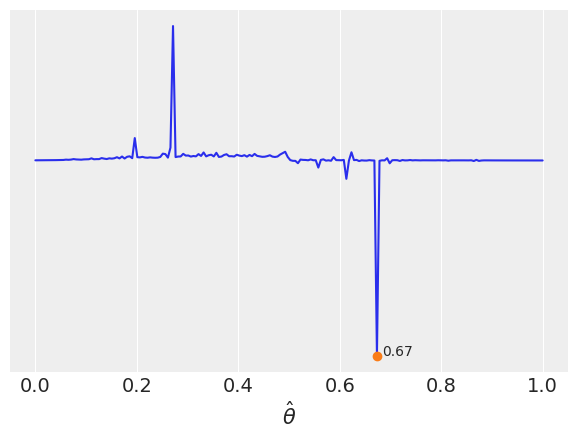

In [48]:
lossf = []
for i in grid:
    if i < 0.5:
        f = np.mean(np.pi * θ_pos / np.abs(i - θ_pos))
    else:
        f = np.mean(1 / (i - θ_pos))
    lossf.append(f)

mini = np.argmin(lossf)
plt.plot(grid, lossf)
plt.plot(grid[mini], lossf[mini], 'o')
plt.annotate('{:.2f}'.format(grid[mini]),
             (grid[mini] + 0.01, lossf[mini] + 0.1))
plt.yticks([])
plt.xlabel(r'$\hat \theta$')
plt.savefig('B11197_02_06.png', dpi=300)

## Gaussian inferences

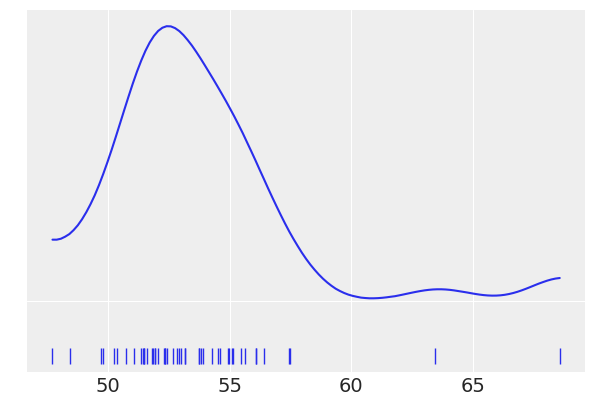

In [55]:
data = np.loadtxt('../data/chemical_shifts.csv')

# remove outliers using the interquartile rule
#quant = np.percentile(data, [25, 75])
#iqr = quant[1] - quant[0]
#upper_b = quant[1] + iqr * 1.5
#lower_b = quant[0] - iqr * 1.5
#data = data[(data > lower_b) & (data < upper_b)]
#print(np.mean(data), np.std(data))

az.plot_kde(data, rug=True)
plt.yticks([0], alpha=0)
plt.savefig('B11197_02_07.png', dpi=300)

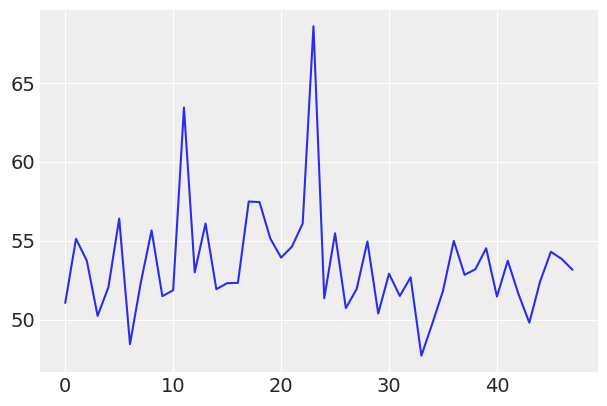

 <img src="B11197_02_08.png" width="500">

In [59]:
data.mean()

53.49645833333333

In [56]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)
    trace_g = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_log__, μ_interval__]
100%|██████████| 1500/1500 [00:01<00:00, 1002.47it/s]
The acceptance probability does not match the target. It is 0.8787004268148455, but should be close to 0.8. Try to increase the number of tuning steps.


In [73]:
trace_g['μ'].mean(), trace_g['σ'].mean()

(53.51059951199551, 3.547994776131686)

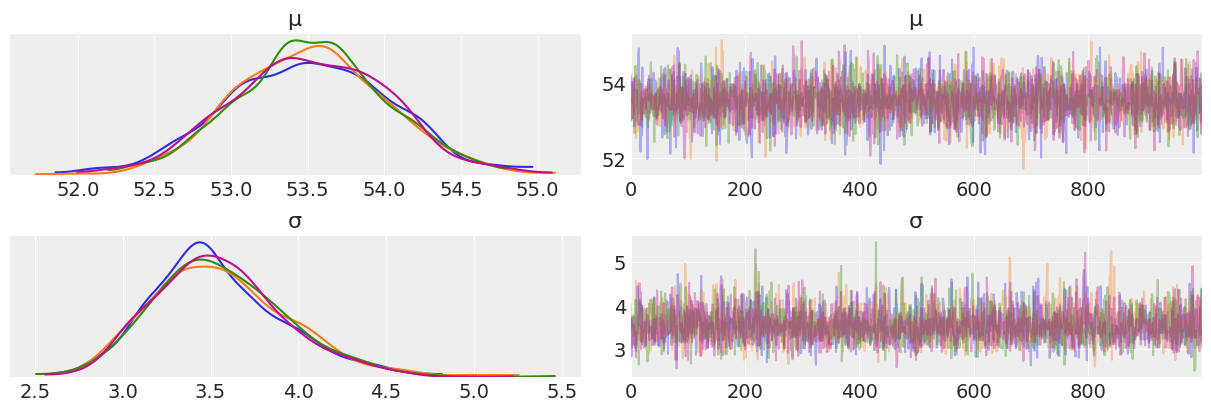

In [74]:
az.plot_trace(trace_g)
plt.savefig('B11197_02_09.png', dpi=300)

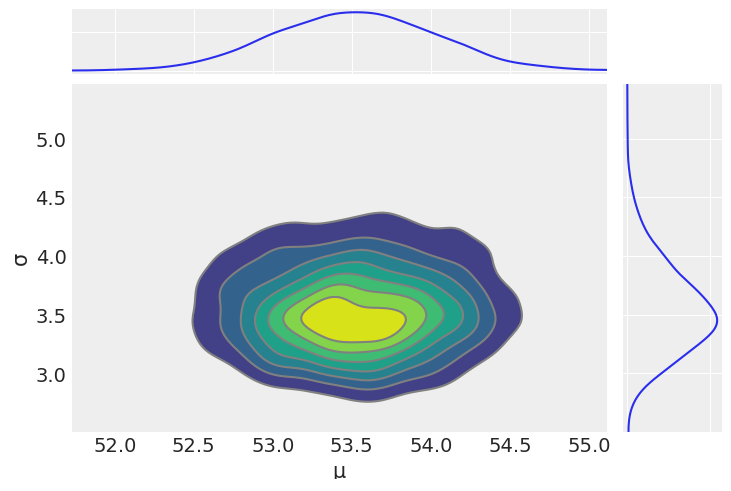

In [75]:
az.plot_joint(trace_g, kind='kde', fill_last=False)
plt.savefig('B11197_02_10.png', dpi=300)

In [78]:
az.summary(trace_g)

,mean,sd,mc error,hpd 3%,hpd 97%,ess,r_hat
μ,53.51,0.50,0.00,52.59,54.47,4139.0,1.0
σ,3.55,0.38,0.01,2.91,4.32,3380.0,1.0


In [ ]:
pm.sample_ppc

In [80]:
y_pred_g = pm.sample_ppc(trace_g, 100, model_g)

100%|██████████| 100/100 [00:00<00:00, 145.63it/s]


In [84]:
y_pred_g['y']

array([53.29569515, 55.37681108, 46.99978801, 49.80450288, 52.7672222 ,
       49.52252168, 60.24365626, 54.81544757, 52.18402391, 56.05608047,
       53.62369657, 46.89187844, 48.08484282, 53.40056415, 53.13232776,
       53.51287835, 55.08989327, 61.50178313, 54.13357922, 51.5024792 ,
       51.3177024 , 49.6353859 , 56.05566395, 51.78887584, 44.48340023,
       50.59304869, 51.93140493, 53.46552116, 48.04582681, 58.20620982,
       54.60334522, 51.42700564, 51.30722433, 52.17896131, 54.00031925,
       57.42527125, 51.06469109, 60.21447772, 56.99701471, 53.81918307,
       54.75530391, 56.90673724, 50.35651455, 56.50803227, 53.12886746,
       51.2978178 , 53.31035459, 49.78487992, 52.57021348, 53.05861226,
       50.20895005, 51.82495516, 55.84268784, 52.69296807, 52.76721503,
       56.9015272 , 58.03131294, 50.94218373, 53.34729   , 53.75095393,
       55.97380221, 49.75346361, 49.86608935, 52.32073072, 53.55610747,
       53.10224312, 51.74052188, 54.09366404, 54.8243278 , 55.62

In [95]:
data_ppc = az.from_pymc3(trace=trace_g, posterior_predictive=y_pred_g)

In [100]:
data_ppc.observed_data

<xarray.Dataset>
Dimensions:  (y_dim_0: 48)
Coordinates:
  * y_dim_0  (y_dim_0) int64 0 1 2 3 4 5 6 7 8 9 ... 39 40 41 42 43 44 45 46 47
Data variables:
    y        (y_dim_0) float64 51.06 55.12 53.73 50.24 ... 54.3 53.84 53.16
Attributes:
    created_at:                 2019-11-10T18:26:12.310830
    inference_library:          pymc3
    inference_library_version:  3.4.1

ValueError: cannot convert float NaN to integer

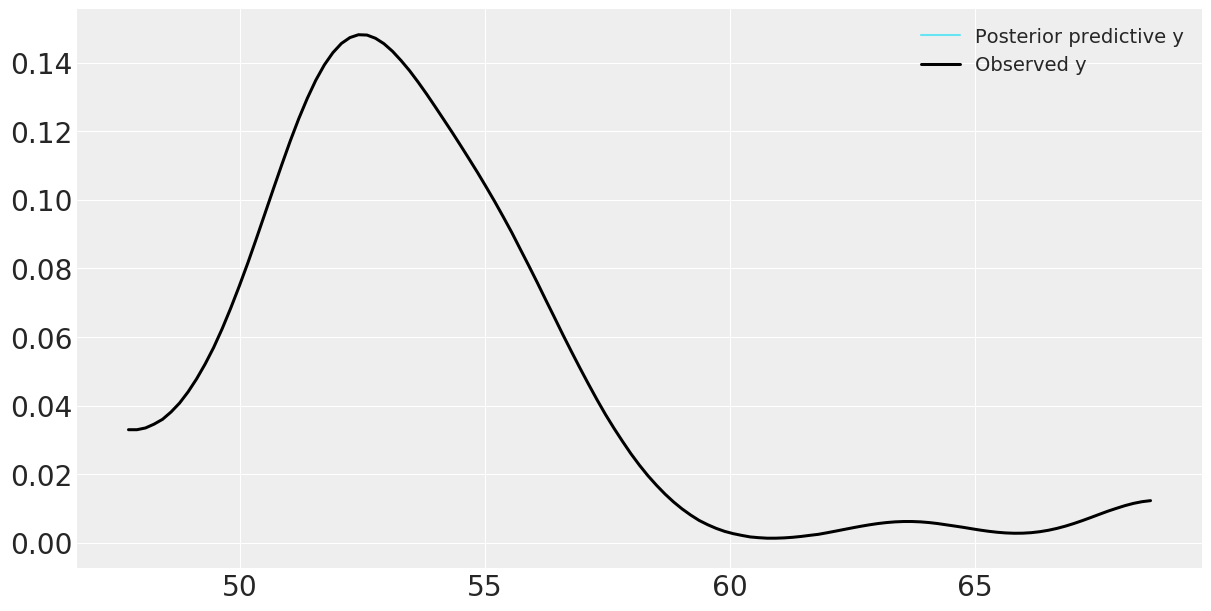

In [101]:
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False)
ax[0].legend(fontsize=15)
plt.savefig('B11197_02_11.png', dpi=300)

### Robust inferences

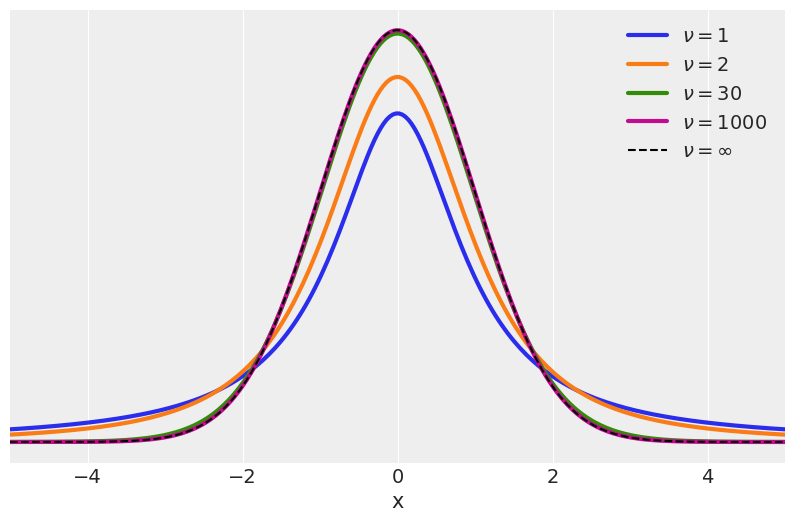

In [103]:
plt.figure(figsize=(10, 6))
x_values = np.linspace(-10, 10, 500)
for df in [1, 2, 30, 1000]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=fr'$\nu = {df}$', lw=3)

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, 'k--', label=r'$\nu = \infty$')
plt.xlabel('x')
plt.yticks([])
plt.legend()
plt.xlim(-5, 5)
plt.savefig('B11197_02_12.png', dpi=300)

 <img src="B11197_02_13.png" width="500">

In [104]:
with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sd=10)
    ν = pm.Exponential('ν', 1/30)
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=data)
    trace_t = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_log__, σ_log__, μ_interval__]
100%|██████████| 1500/1500 [00:01<00:00, 904.77it/s] 


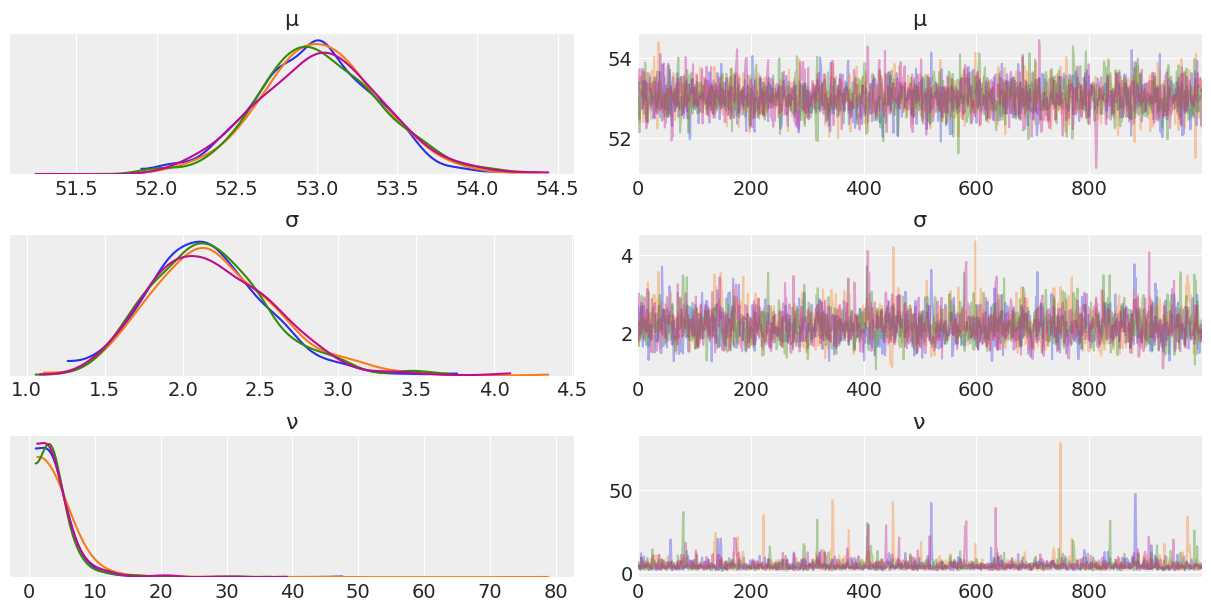

In [105]:
az.plot_trace(trace_t)
plt.savefig('B11197_02_14.png', dpi=300)

In [106]:
az.summary(trace_t)

,mean,sd,mc error,hpd 3%,hpd 97%,ess,r_hat
μ,53.01,0.38,0.01,52.30,53.73,2936.0,1.0
σ,2.18,0.40,0.01,1.47,2.91,2053.0,1.0
ν,4.49,3.69,0.09,1.22,8.90,1845.0,1.0


100%|██████████| 100/100 [00:00<00:00, 1591.25it/s]


ValueError: cannot convert float NaN to integer

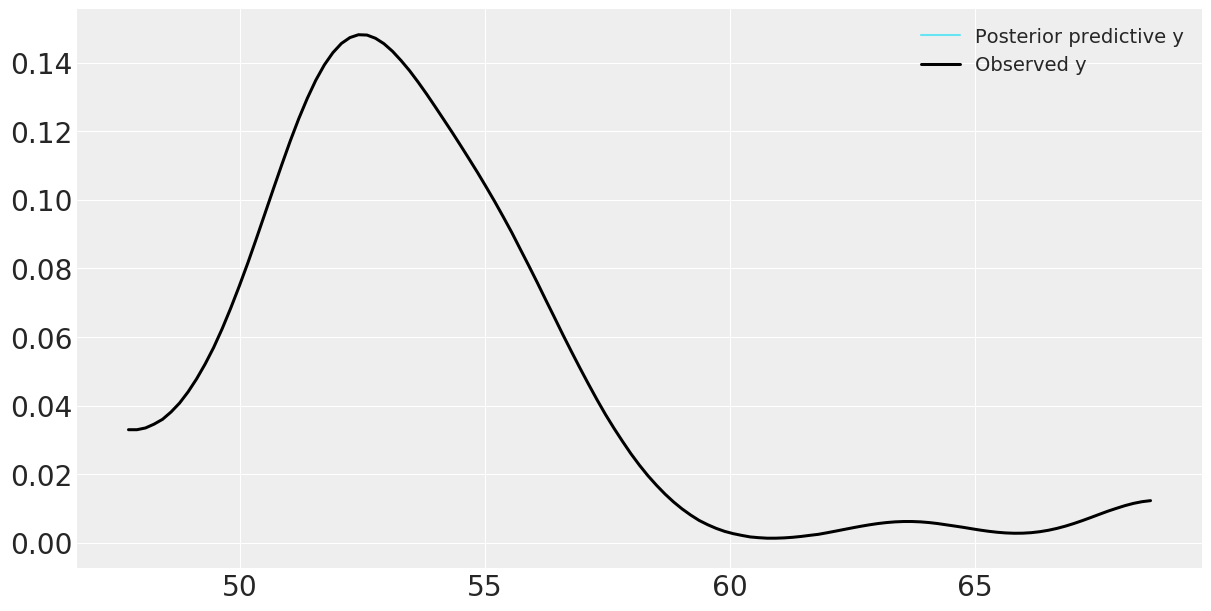

In [108]:
y_ppc_t = pm.sample_ppc(
    trace_t, 100, model_t, random_seed=123)
y_pred_t = az.from_pymc3(trace=trace_t, posterior_predictive=y_ppc_t)
az.plot_ppc(y_pred_t, figsize=(12, 6), mean=False)
ax[0].legend(fontsize=15)
plt.xlim(40, 70)
plt.savefig('B11197_02_15.png', dpi=300)

# Tips example

In [ ]:
tips = pd.read_csv('../data/tips.csv')
tips.tail()

In [ ]:
sns.violinplot(x='day', y='tip', data=tips)
plt.savefig('B11197_02_16.png', dpi=300)

In [ ]:
tip = tips['tip'].values
idx = pd.Categorical(tips['day'],
                     categories=['Thur', 'Fri', 'Sat', 'Sun']).codes
groups = len(np.unique(idx))

In [ ]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=tip)

    trace_cg = pm.sample(5000)
az.plot_trace(trace_cg)
plt.savefig('B11197_02_17.png', dpi=300)

In [ ]:
dist = stats.norm()

_, ax = plt.subplots(3, 2, figsize=(14, 8), constrained_layout=True)

comparisons = [(i, j) for i in range(4) for j in range(i+1, 4)]
pos = [(k, l) for k in range(3) for l in (0, 1)]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = trace_cg['μ'][:, i] - trace_cg['μ'][:, j]
    d_cohen = (means_diff / np.sqrt((trace_cg['σ'][:, i]**2 + trace_cg['σ'][:, j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(
        0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax[k, l].legend()
plt.savefig('B11197_02_18.png', dpi=300)

# Hierarchical Models

 <img src="B11197_02_19.png" width="500">

In [ ]:
N_samples = [30, 30, 30]
G_samples = [18, 18, 18]  # [3, 3, 3]  [18, 3, 3]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

In [ ]:
with pm.Model() as model_h:
    μ = pm.Beta('μ', 1., 1.)
    κ = pm.HalfNormal('κ', 10)

    θ = pm.Beta('θ', alpha=μ*κ, beta=(1.0-μ)*κ, shape=len(N_samples))
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data)

    trace_h = pm.sample(2000)

In [ ]:
az.plot_trace(trace_h)
plt.savefig('B11197_02_20.png', dpi=300)

In [ ]:
az.summary(trace_h)

In [ ]:
x = np.linspace(0, 1, 100)
for i in np.random.randint(0, len(trace_h), size=100):
    u = trace_h['μ'][i]
    k = trace_h['κ'][i]
    pdf = stats.beta(u*k, (1.0-u)*k).pdf(x)
    plt.plot(x, pdf,  'C1', alpha=0.2)

u_mean = trace_h['μ'].mean()
k_mean = trace_h['κ'].mean()
dist = stats.beta(u_mean*k_mean, (1.0-u_mean)*k_mean)
pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)
plt.plot(x, pdf, lw=3, label=f'mode = {mode:.2f}\nmean = {mean:.2f}')
plt.yticks([])

plt.legend()
plt.xlabel('$θ_{prior}$')
plt.tight_layout()
plt.savefig('B11197_02_21.png', dpi=300)

In [ ]:
cs_data = pd.read_csv('../data/chemical_shifts_theo_exp.csv')
diff = cs_data.theo.values - cs_data.exp.values
idx = pd.Categorical(cs_data['aa']).codes
groups = len(np.unique(idx))

In [ ]:
with pm.Model() as cs_nh:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff)

    trace_cs_nh = pm.sample(1000)

In [ ]:
with pm.Model() as cs_h:
    # hyper_priors
    μ_μ = pm.Normal('μ_μ', mu=0, sd=10)
    σ_μ = pm.HalfNormal('σ_μ', 10)

    # priors
    μ = pm.Normal('μ', mu=μ_μ, sd=σ_μ, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff)

    trace_cs_h = pm.sample(1000)

In [ ]:
_, axes = az.plot_forest([trace_cs_nh, trace_cs_h],
                         model_names=['n_h', 'h'],
                         var_names='μ', combined=False, colors='cycle')
y_lims = axes[0].get_ylim()
axes[0].vlines(trace_cs_h['μ_μ'].mean(), *y_lims)
plt.savefig('B11197_02_22.png', dpi=300)